In [4]:
import numpy as np
import cv2
import time
import datetime
import os
import shutil
import dill
import pandas as pd
import warnings
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.models import Sequential, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.neighbors.kde import KernelDensity
from matplotlib import pyplot as plt
# import plotly.graph_objects as go
# import plotly.offline as pyo
# pyo.init_notebook_mode(connected=True)

c:\users\andrey\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
class VideoStream:
    
    def __init__(self, filepath):
        self.cap = cv2.VideoCapture(filepath)
        if not self.cap.isOpened():
            raise Exception('Video stream doesn\'t open!')
    
    def __enter__(self):
        return self.cap
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.cap.release()

In [6]:
class ShortVideoWarning(UserWarning):
    
    def __init__(self, message):
        super().__init__()
        self.message = message
        
    def __str__(self):
        return self.message

In [27]:
class ImageSequenceGenerator():
    
    # public
    def __init__(
        self,
        directory,
#         class_mode='categorical',
        target_size=(256, 256),
        timesteps_cnt=75,
        batch_size=32,
        fps=5,
        step=10,
        shuffle=True,
        seed=None
    ):
        self.directory = directory
        self.target_size = target_size
        self.timesteps_cnt = timesteps_cnt
        self.step=step
        self.classes = os.listdir(self.directory)
        self.seed = seed
        self.shuffle = shuffle
        self.video_stats = None
        self.start_positions = None
        self.batch_size=batch_size
        self.fps = fps
    
    # private
    def __get_video_classes(self):
        map_video_class = []
        for c in self.classes:
            class_path = os.path.join(self.directory, c)
            video_names = os.listdir(class_path)
            videos = list(map(lambda x: os.path.join(class_path, x), video_names))
            class_ = [c] * len(videos)
            map_ = list(zip(videos, class_))
            map_video_class.extend(map_)
        return map_video_class
    
    # private
    def collect_video_stats(self):
        map_video_class = self.__get_video_classes()
        self.video_stats = []
        short_video_stats = []
        for video, class_ in map_video_class:
            with VideoStream(video) as cap:
                frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = cap.get(cv2.CAP_PROP_FPS)
                if self.fps is None:
                    step_size = 1
                else:
                    step_size = int(np.ceil(fps / self.fps))
            if frames_cnt < self.timesteps_cnt * step_size:
                short_video_stats.append((video, class_, frames_cnt, fps))
            else:
                self.video_stats.append((video, class_, frames_cnt, fps))
        if len(short_video_stats) != 0:
            warn_message  = '\nSome videos have skipped because of too short for choosen timesteps.\n'
            warn_message += 'Timesteps: {}\n'.format(self.timesteps_cnt)
            short_videos = ['Video: {}; Class: {}; Frames: {}'.format(i[0], i[1], i[2]) for i in short_video_stats]
            warn_message += '{}'.format('\n'.join(short_videos))
            warnings.warn(ShortVideoWarning(warn_message))
        print('Found {} videos belonging to {} classes'.format(len(self.video_stats), len(self.classes)))
        self.start_positions = []
        for video, class_, frames_cnt, fps in self.video_stats:
            if self.fps is None:
                step_size = 1
            else:
                step_size = int(np.ceil(fps / self.fps))
            for start_position in range(0, frames_cnt - self.timesteps_cnt * step_size, self.step * step_size):
                self.start_positions.append((video, class_, start_position))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.start_positions)
    
    # public
    def get_batch_generator(self):
        item = 0
        while True:
            batch_start_positions = self.start_positions[item:item + self.batch_size]
            batch = []
            for video, class_, start_position in tqdm_notebook(batch_start_positions):
                with VideoStream(video) as cap:
                    fps = cap.get(cv2.CAP_PROP_FPS)
                    if self.fps is None:
                        step_size = 1
                    else:
                        step_size = int(np.ceil(fps / self.fps))
                    frame_sequence = []
                    current_pos = start_position
                    for i in range(self.timesteps_cnt):
                        cap.set(cv2.CAP_PROP_POS_FRAMES, current_pos)
                        ret, frame = cap.read()
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame = cv2.resize(frame, self.target_size)
                        frame_sequence.append(frame)
                        current_pos += step_size
                    frame_sequence = np.array(frame_sequence)
                batch.append(frame_sequence)
            batch = np.array(batch)
            yield batch
            item += self.batch_size
            if item == len(self.start_positions):
                item = 0

In [28]:
tmp = ImageSequenceGenerator('../videos/cut/train/', fps=5, timesteps_cnt=75, seed=188, shuffle=False)
tmp.collect_video_stats()
tmp_gen = tmp.get_batch_generator()

Found 5 videos belonging to 2 classes


In [29]:
tmp.start_positions

[('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4', '0', 0),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  60),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  120),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  180),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  240),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  300),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  360),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  420),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  480),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  540),
 ('../videos/cut/train/0\\Football Fights & Furious Moments - HD.mp4',
  '0',
  600),
 ('../videos/cut/train/0\\Football Fights & Furious Moments -

In [30]:
x = next(tmp_gen)

In [10]:
x.shape

(32, 75, 256, 256, 3)

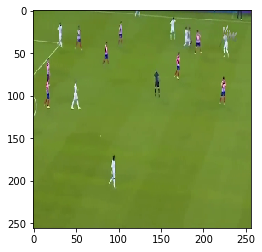

In [23]:
plt.imshow(x[0][17])

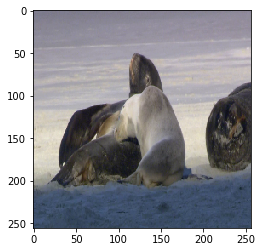

In [131]:
plt.imshow(seq[2])

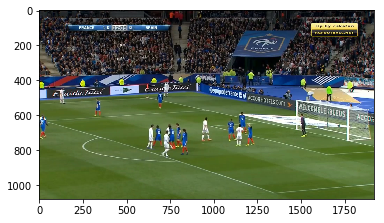

In [63]:
def get_random_sequence(filepath, timesteps_cnt):
    frame_sequence = []
    with VideoStream(filepath) as cap:
        frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start = np.random.randint(0, frames_cnt - timesteps_cnt)
        end = start + timesteps_cnt
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        for i in range(start, end):
            ret, frame = cap.read()
            if ret == True:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_sequence.append(frame)
            else:
                break
    frame_sequence = np.array(frame_sequence)
    return frame_sequence
    
tmp = get_random_sequence('../videos/input/train/0/video.mp4', 10)

In [66]:
np.random.randint(0, 1)

0

'../videos/cut/train/0\\France_Spain_1_32_00_1_38_00.mp4'

In [59]:
timesteps_cnt = 10

frame_sequence = []
with VideoStream('../videos/input/train/0/video.mp4') as cap:
    frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    start = np.random.randint(0, frames_cnt - timesteps_cnt)
    end = start + timesteps_cnt
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)
    for i in range(start, end):
        ret, frame = cap.read()
        if ret == True:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_sequence.append(frame)
        else:
            break
frame_sequence = np.array(frame_sequence)

In [62]:
frame_sequence.shape

(10, 1080, 1920, 3)

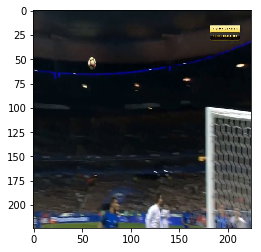

In [64]:
img = cv2.resize(frame, (224, 224))
plt.imshow(img)

In [ ]:
class ImageSequenceGenerator(Sequence):
    
    def __init__(
        self,
        directory,
        target_size=(256, 256),
        class_mode='categorical',
        batch_size=32
    ):
        

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)